In [1]:
#Imports 
import imutils
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
import numpy as np

import argparse
import os
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import *


<h1>Load dataset </h1>

In [2]:
# load data 

male_data=np.load('male_data.npy',allow_pickle=True)
female_data=np.load('female_data.npy',allow_pickle=True)

<h1> Initialized paramters of cold features</h1>

In [3]:
#Initialization:
N_RHO_BINS = 7
N_ANGLE_BINS = 12
N_BINS = N_RHO_BINS * N_ANGLE_BINS
BIN_SIZE = 360 // N_ANGLE_BINS
R_INNER = 5.0
R_OUTER = 35.0
K_S = np.arange(3, 8)

<h1> Cold Features Algorithm</h1>

<li> Preprocessing step</li>

In [4]:
def preprocess_image(im, show_images = True , sharpness_factor = 10, bordersize = 3):
    enhancer = ImageEnhance.Sharpness(im)
    im_s_1 = enhancer.enhance(sharpness_factor)
    
    (width, height) = (im.width * 2, im.height * 2)
    im_s_1 = im_s_1.resize((width, height))
    if show_images: plt.imshow(im_s_1, cmap='gray')
    image = np.array(im_s_1)
    image = cv2.copyMakeBorder(
        image,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255]
    )
    orig_image = image.copy()
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.GaussianBlur(image,(3,3),0)
    if show_images: plt.imshow(image, cmap='gray')
    (thresh, bw_image) = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    if show_images: plt.imshow(bw_image, cmap='gray')
    return bw_image, orig_image

<li> Get the contours of the text words </li>

In [5]:
def get_contour_pixels(bw_image,show_images = True ):
        contours, _= cv2.findContours(
            bw_image, cv2.RETR_TREE, 
            cv2.CHAIN_APPROX_NONE
            ) 
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]
        
        img2 = bw_image.copy()[:,:,np.newaxis]
        img2 = np.concatenate([img2, img2, img2], axis = 2)
        if show_images:
            for cnt in contours : 
                cv2.drawContours(img2, [cnt], 0, (255, 0, 0), 1)  
                
            plt.imshow(img2, cmap='gray')
        return contours

<li> Extract curvture features of the text</li>

In [6]:
def get_cold_features(img_file, approx_poly_factor = 0.01 , sharpness_factor = 10 , bordersize = 3):

    bw_image, _ = preprocess_image(img_file, sharpness_factor, bordersize)
    contours = get_contour_pixels(bw_image)
    
    rho_bins_edges = np.log10(np.linspace(R_INNER, R_OUTER, N_RHO_BINS))
    feature_vectors = np.zeros((len(K_S), N_BINS))
    
    for j, k in enumerate(K_S):
        hist = np.zeros((N_RHO_BINS, N_ANGLE_BINS))
        for cnt in contours:
            epsilon = approx_poly_factor * cv2.arcLength(cnt,True)
            cnt = cv2.approxPolyDP(cnt,epsilon,True)
            n_pixels = len(cnt)
            
            point_1s = np.array([point[0] for point in cnt])
            x1s, y1s = point_1s[:, 0], point_1s[:, 1]
            point_2s = np.array([cnt[(i + k) % n_pixels][0] for i in range(n_pixels)])
            x2s, y2s = point_2s[:, 0], point_2s[:, 1]
            
            thetas = np.degrees(np.arctan2(y2s - y1s, x2s - x1s) + np.pi)
            rhos = np.sqrt((y2s - y1s) ** 2 + (x2s - x1s) ** 2)
            if(rhos.all()):
                rhos_log_space = np.log10(rhos)
            else:
                rhos_log_space = rhos
            
            quantized_rhos = np.zeros(rhos.shape, dtype=int)
            for i in range(N_RHO_BINS):
                quantized_rhos += (rhos_log_space < rho_bins_edges[i])
                
            for i, r_bin in enumerate(quantized_rhos):
                theta_bin = int(thetas[i] // BIN_SIZE) % N_ANGLE_BINS
                hist[r_bin - 1, theta_bin] += 1
            
        normalised_hist = hist / hist.sum()
        feature_vectors[j] = normalised_hist.flatten()
        
    return feature_vectors.flatten()

<h1> Train the classifier </h1>

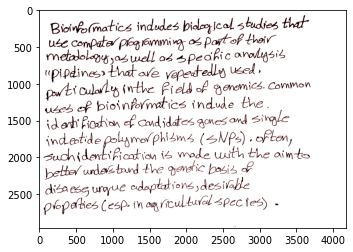

In [22]:
cold_features = []
for i in range(0,len(male_data)-62):
    image = male_data[i]
    height = image.shape[0]
    width  = image.shape[1]
    slice  = (int)(height/2)
    cropped_image =  np.copy(image[10:slice,:])
    image = Image.fromarray(cropped_image)
    cold_features.append(get_cold_features(image))

for i in range(0,len(female_data)-66):
    image = female_data[i]
    height = image.shape[0]
    width  = image.shape[1]
    slice  = (int)(height/2)
    cropped_image =  np.copy(image[10:slice,:])
    image = Image.fromarray(cropped_image)
    cold_features.append(get_cold_features(image))




In [25]:
print(len(cold_features))

130


In [26]:
x_cold = cold_features
y = ["male"] * 63 + ["female"] * 67
 
cs = MinMaxScaler()
x_ = cs.fit_transform(x_cold)
x_ = np.nan_to_num(x_)
clf = SVC(kernel='rbf', verbose=True, C=10)
scores = cross_val_score(clf, x_, y, cv=10)
print(scores)
y_pred_cold = cross_val_predict(clf, x_, y, cv=10)


print('Confusion Matrix')
cf = confusion_matrix(y, y_pred_cold)
cf_sum = cf.sum(axis = 1)[:, np.newaxis]
cf = np.round(cf / cf_sum * 100, 2)
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(repr(cf))

cr = 0.0
for i in range(0, cf.shape[0]):
    cr += cf[i][i]
    
cr /= cf.shape[0]
print(f'classification rate = {np.round(cr, 2)}')

print(classification_report(y, y_pred_cold))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][0.31 0.69 0.69 0.85 0.77 0.62 0.77 0.54 0.69 0.69]
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Confusion Matrix
array([[70.15, 29.85],
       [38.10, 61.90]])
classification rate = 66.03
              precision    recall  f1-score   support

      female       0.66      0.70      0.68        67
        male       0.66      0.62      0.64        63

    accuracy                           0.66       130
   macro avg       0.66      0.66      0.66       130
weighted avg       0.66      0.66      0.66       130



<h1> Test the classifier </h1>

<li>Calculate the cold features for the test data</li>

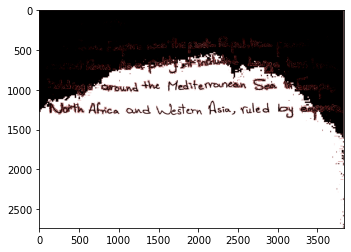

In [23]:
# Test :
cold_features_test = []
for i in range(len(male_data)-62,len(male_data)):
    image = male_data[i]
    height = image.shape[0]
    width  = image.shape[1]
    slice  = (int)(height/2)
    cropped_image =  np.copy(image[10:slice,:])
    image = Image.fromarray(cropped_image)
    cold_features_test.append(get_cold_features(image))

for i in range(len(female_data)-66,len(female_data)):
    image = female_data[i]
    height = image.shape[0]
    width  = image.shape[1]
    slice  = (int)(height/2)
    cropped_image =  np.copy(image[10:slice,:])
    image = Image.fromarray(cropped_image)
    cold_features_test.append(get_cold_features(image))

<li> Feed the classifier with those features and compare with the true results</li>

In [31]:
y_test  = ["male"] * 62 + ["female"] * 66
clf.fit(x_cold, y)
print(clf.predict(cold_features_test))
print(clf.score(cold_features_test, y_test)*100)

[LibSVM]['male' 'female' 'male' 'male' 'male' 'female' 'male' 'male' 'male' 'male'
 'female' 'male' 'female' 'male' 'male' 'male' 'male' 'male' 'male' 'male'
 'male' 'female' 'male' 'male' 'male' 'male' 'female' 'female' 'male'
 'male' 'male' 'female' 'female' 'male' 'male' 'male' 'male' 'male'
 'female' 'male' 'female' 'male' 'male' 'male' 'male' 'female' 'female'
 'female' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'female'
 'female' 'female' 'male' 'female' 'male' 'male' 'female' 'female'
 'female' 'male' 'male' 'female' 'female' 'male' 'female' 'male' 'female'
 'male' 'female' 'female' 'female' 'female' 'female' 'female' 'female'
 'female' 'female' 'male' 'female' 'male' 'female' 'male' 'female'
 'female' 'female' 'female' 'female' 'female' 'male' 'male' 'female'
 'female' 'female' 'female' 'female' 'female' 'female' 'female' 'female'
 'female' 'female' 'male' 'male' 'female' 'male' 'male' 'female' 'male'
 'female' 'female' 'male' 'male' 'female' 'female' 'female' 'female'
 '